In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker

import os
import urllib
import re
import random
import json
from typing import List, Dict, Optional, Any, Tuple
import glob

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import pickle
from torch.nn import functional as F

from collections import OrderedDict, Counter

In [2]:
import tokenizers
#from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.pre_tokenizers import Punctuation

from tokenizers import normalizers
from tokenizers.normalizers import Lowercase, Strip, Replace, Sequence
from tokenizers.trainers import UnigramTrainer

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(1)

In [4]:
TILDE_DATA = './data/tilde'
!mkdir -p $TILDE_DATA


In [5]:
#!pip install sacrebleu
!pip show sacrebleu

Name: sacrebleu
Version: 1.5.1
Summary: Hassle-free computation of shareable, comparable, and reproducible BLEU, chrF, and TER scores
Home-page: https://github.com/mjpost/sacrebleu
Author: Matt Post
Author-email: post@cs.jhu.edu
License: Apache License 2.0
Location: /home/gstrazds/anaconda3/envs/tw131/lib/python3.8/site-packages
Requires: portalocker
Required-by: 


#Text preprocessing

In [6]:
num_bpe_merges = 10000
vocab_size = 5500
joint_vocab_size = 2*vocab_size

!echo BPE_ops=$num_bpe_merges vocab_size=$vocab_size joint_vocab_size=$joint_vocab_size

BPE_ops=10000 vocab_size=5500 joint_vocab_size=11000


In [7]:
#!pip install subword-nmt
!pip show subword-nmt

Name: subword-nmt
Version: 0.3.7
Summary: Unsupervised Word Segmentation for Neural Machine Translation and Text Generation
Home-page: https://github.com/rsennrich/subword-nmt
Author: Rico Sennrich
Author-email: None
License: MIT
Location: /home/gstrazds/anaconda3/envs/tw131/lib/python3.8/site-packages
Requires: 
Required-by: 


In [8]:
TILDE_ALL_EN = f'{TILDE_DATA}/all.norm2.en'
TILDE_ALL_LV = f'{TILDE_DATA}/all.norm2.lv'

TILDE_TOK_EN = f'{TILDE_DATA}/combined.en.tok.txt'
TILDE_TOK_LV = f'{TILDE_DATA}/combined.lv.tok.txt'

!echo $TILDE_DATA/combined.lv.tok.txt $TILDE_TOK_EN

./data/tilde/combined.lv.tok.txt ./data/tilde/combined.en.tok.txt


In [9]:
# !git clone https://github.com/moses-smt/mosesdecoder.git

In [10]:
# # Read texts from previously saved files.


In [11]:
with open(f'{TILDE_DATA}/combined.lv.BPE.txt', 'r') as f:
    text_input = f.read().splitlines()

with open(f'{TILDE_DATA}/combined.en.BPE.txt', 'r') as f:
    text_output = f.read().splitlines()
    

with open('data/tilde/train2.lv', 'r') as f:
    train_input = f.read().splitlines()

with open('data/tilde/test2.lv', 'r') as f:
    test_input = f.read().splitlines()

with open('data/tilde/valid2.lv', 'r') as f:
    valid_input = f.read().splitlines()

with open('data/tilde/train2.en', 'r') as f:
    train_output = f.read().splitlines()

with open('data/tilde/test2.en', 'r') as f:
    test_output = f.read().splitlines()

with open('data/tilde/valid2.en', 'r') as f:
    valid_output = f.read().splitlines()


In [12]:
print("total:\t", len(text_input), len(text_output))
print(f"train:\t {len(train_input)} {len(train_output)}")
print(f"valid:\t  {len(valid_input)}  {len(valid_output)}")
print(f"test:\t  {len(test_input)}  {len(test_output)}")



total:	 1613611 1613611
train:	 1210208 1210208
valid:	  161361  161361
test:	  242042  242042


In [13]:
def build_vocab(freq_file):
    vocab = Counter()  #['<unk>', '<pad>', '<eos>'])
    with open(freq_file, 'r') as f:
        for line in f.readlines():
            token, num_occurs = line.split()
            vocab[token] += int(num_occurs)
    return vocab #[:vocab_size]

en_vocab = build_vocab(f'{TILDE_DATA}/bpe/vocab.en')
lv_vocab = build_vocab(f'{TILDE_DATA}/bpe/vocab.lv')
joint_vocab = build_vocab(f'{TILDE_DATA}/bpe/vocab.lven')



In [14]:
print("en_vocab:", len(en_vocab), "lv_vocab:", len(lv_vocab), "joint_vocab", len(joint_vocab))
# en_vocab: 10099 lv_vocab: 6477 joint_vocab 10519

en_vocab: 10099 lv_vocab: 6477 joint_vocab 10519


In [15]:
if False:
    special_tokens = ['<unk>', '<pad>', '<eos>', '<sep>'] #, '<S>', '</S>', '<bos>', '<eos>', '<sep>', '<NONE>', '<|>']
                  
    normalizer = normalizers.Sequence([Strip(), Lowercase()])
    pre_tokenizer = Whitespace()

    model = tokenizers.models.WordLevel(unk_token='<unk>')
    # model = tokenizers.models.WordPiece()
    tokenizer = tokenizers.Tokenizer(model=model)


    tokenizer.add_special_tokens(special_tokens)
    tokenizer.normalizer = normalizer
    tokenizer.pre_tokenizer = pre_tokenizer

    # filelist = glob.glob(PTHRU_DIR+"valid/*.pthru")
    # filelist.extend( glob.glob(PTHRU_DIR+"test/*.pthru"))
    # filelist.extend( glob.glob(PTHRU_DIR+"train/*.pthru"))


    # token_strs = [tok for (tok, span) in pre_tokenizer.pre_tokenize_str(str1)]
    # print(token_strs)

    # filelist = glob.glob(PTHRU_DIR+"valid/*.pthru")

    filelist = glob.glob(f"{TILDE_DATA}/combined.*.BPE.txt")

    filelist = sorted(filelist)
    print(len(filelist), filelist[:10])


    # unigram_trainer = tokenizers.trainers.UnigramTrainer()
    # trainer = tokenizers.trainers.WordPieceTrainer(vocab_size=vocab_size)
    trainer = tokenizers.trainers.WordLevelTrainer(vocab_size=joint_vocab_size, special_tokens=special_tokens)

    tokenizer.train(files=filelist, trainer=trainer)

    vocab_dict = tokenizer.get_vocab(with_added_tokens=False)
    print("ACTUAL VOCAB SIZE =", len(vocab_dict))
    print(vocab_dict)


In [16]:
# ACTUAL VOCAB SIZE = 9048  #? Why is this not == len(joint_vocab) ?

#MinGPT

In [47]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

def calculate_attention_token(attention, top_k, model):
    logits = model.head(attention)
    logits = logits[:, -1, :]
    logits = top_k_logits(logits, top_k)

    probs = F.softmax(logits)

    _, ix = torch.topk(probs, k=1, dim=-1)
    ix = torch.multinomial(probs, num_samples=top_k)

    return ix[0]


@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None,
           output_attention=False, stop_tokidx=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    attention_state = [[] for _ in model.blocks]

    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)

        if output_attention:
            b, t = x.size()

            for block_id in range(len(model.blocks)):
                att = model.blocks[block_id].attn.att
                attention_state[block_id].append(att)

        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)
        if stop_tokidx is not None and ix == stop_tokidx:
            break

    if output_attention:
        return x, attention_state

    return x


In [18]:
"""
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

logger = logging.getLogger(__name__)

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.att = None

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))

        self.att = att

        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)

        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(idx) # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[:, :t, :] # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss


In [19]:
"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import sacrebleu
import math
import logging
from random import choice

from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

logger = logging.getLogger(__name__)

def clean_tokens(sentence):
    return sentence.replace('@@ ', '').replace(' @', '').replace('@ ', '')

class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, valid_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.valid_dataset = valid_dataset
        self.config = config

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self, postfix=''):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        checkpoint_path = self.config.ckpt_path + postfix + '.pt'
        logger.info("saving %s", checkpoint_path)
        torch.save(raw_model.state_dict(), checkpoint_path)

    def train(self):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset
            if split == 'test':
                data = self.test_dataset
            elif split == 'valid':
                data = self.valid_dataset
                model.eval()
            loader = DataLoader(data, shuffle=True, pin_memory=True,
                                batch_size=config.batch_size, # if is_train else 8,
                                num_workers=config.num_workers)

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
#             predicted_tokids = None
            context_list = []
            translation_results = []
            eval_results = []
            x_total = None
            y_total = None
            for it, (x, y) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    logits, loss = model(x, y)
                    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())
                    if split == 'valid':
                        intent = (x == valid_dataset.tokenizer_input.encode(['<eos>'])[0]).nonzero(as_tuple=True) #[0]
                        #print(valid_dataset.tokenizer_input.encode(['<eos>']))
                        #print(intent)
                        #print(x.shape, y.shape, logits.shape)
                        #for i in range(len(intent[0])):
                        #    print(x[i][intent[1][i]], end=", ")
                        #print()

                        probs = F.softmax(logits, dim=-1)
                        #print(probs.shape)
                        for i in range(len(probs)):
                            # sample from the distribution or take the most likely
                            _, predicted = torch.topk(probs[i], k=1, dim=-1)
                            if len(predicted.shape) > 1:
                                # print("PREDICTED:", predicted.shape, predicted)
                                predicted = predicted.squeeze()
                                if len(predicted.shape) > 1:
                                    print("AFTER predicted.squeeze(1):", predicted.shape)
                            sep = intent[1][i]
                            # print("sep=", sep)
                            #print("***CONTEXT")
                            context = clean_tokens(data.tokenizer_input.decode(x[i][:sep - 1], True))
                            #print(context)
                            #print("***COMPLETION")
                            completion = clean_tokens(data.tokenizer_output.decode(predicted[sep:], True))
                            #print(completion)
                            #print("***REAL")
                            real = clean_tokens(data.tokenizer_output.decode(y[i][sep:], True))
                            #print(real)
                            context_list.append(context)
                            translation_results.append(completion)
                            eval_results.append(real)

#                         probs = F.softmax(logits, dim=-1)
#                         # sample from the distribution or take the most likely
#                         _, predicted = torch.topk(probs, k=1, dim=-1)

#                         if predicted_tokids is None:
#                             predicted_tokids = [predicted]
#                             x_total = x
#                             y_total = y
#                         else:
#                             predicted_tokids.append(predicted)
#                             x_total = torch.cat((x_total, x), dim=0)
#                             y_total = torch.cat((y_total, y), dim=0)
                        

                if is_train:
                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. mean loss: {float(np.mean(losses)):.5f}. lr {lr:e}")

            if split == 'train':
                train_loss = float(np.mean(losses))
                print(f"train loss: {train_loss}")
                return train_loss

            if split == 'test':
                test_loss = float(np.mean(losses))
                print(f"test loss: {test_loss}")
                return test_loss

            if split == 'valid':
                test_loss = float(np.mean(losses))
                print(f"valid loss: {test_loss}")

#                 eval_results = []
#                 translation_results = []
#                 context_list = []

#                 for idx in range(len(logits_total)):
#                     intent = (x_total[idx] == valid_dataset.tokenizer_input.encode(['<eos>'])[0]).nonzero(as_tuple=True)[0][0]
#                     probs = F.softmax(logits_total[idx], dim=-1)
#                     # sample from the distribution or take the most likely
#                     _, predicted = torch.topk(probs, k=1, dim=-1)
#                 for idx in range(len(predicted_tokids)):
#                     intent = (x_total[idx] == valid_dataset.tokenizer_input.encode(['<eos>'])[0]).nonzero(as_tuple=True)[0][0]
#                     predicted = predicted_tokids[idx]
#                     print("***CONTEXT")
#                     context = clean_tokens(data.tokenizer_input.decode(x_total[idx][:intent - 1], True))
#                     print("***COMPLETION")
#                     completion = clean_tokens(data.tokenizer_output.decode(predicted[intent:], True))
#                     print("***REAL")
#                     real = clean_tokens(data.tokenizer_output.decode(y_total[idx][intent:], True))

#                     context_list.append(context)
#                     translation_results.append(completion)
#                     eval_results.append(real)
                
                with open('valid.txt', 'w') as f:
                    f.write("\n".join(translation_results))

                with open('eval.txt', 'w') as f:
                    f.write("\n".join(eval_results))

                with open('context.txt', 'w') as f:
                    f.write("\n".join(context_list))


                !cat valid.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > valid.detok.txt
                !cat eval.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > eval.detok.txt
                !cat context.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > context.detok.txt

                with open('eval.detok.txt', 'r') as f:
                    eval_results = [l.strip() for l in f.readlines()]
                with open('valid.detok.txt', 'r') as f:
                    translation_results = [l.strip() for l in f.readlines()]
                with open('context.detok.txt', 'r') as f:
                    context_list = [l.strip() for l in f.readlines()]

#                 idx = choice(range(len(context_list)))
                valid_sentences = ['the driver wore a cap and his face was thin and very tanned.',
                                   'outside it was getting dark.',
                                   'the two girls were asleep.',
                                   'I would like to have had the uniform off although I did not care much about the outward forms.',
                                   'I watched the flashes on San Gabriele.',
                                   'I asked.',
                                   '"no.']

                idx_list = [i for i, sentence in enumerate(eval_results) if sentence in valid_sentences]
                
                for idx in idx_list:
                    print(f'Input:            {context_list[idx]}')
                    print(f'Predicted output: {translation_results[idx]}')
                    print(f'Real output:      {eval_results[idx]}')
                    print('--------------------------------------------------')

                refs = [eval_results]
                sys = translation_results
                bleu = sacrebleu.corpus_bleu(sys, refs)
                print(f'BLEU: {bleu.score}')
                print('##############################################################')

                return test_loss, bleu.score

        train_loss_list = []
        test_loss_list = []
        valid_loss_list = []
        valid_bleu_list = []
        best_loss = float('inf')
        best_bleu = 0.0
        bleu_score = -1.0
        self.tokens = 0 # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            train_loss = run_epoch('train')
            train_loss_list.append(train_loss)
            if self.test_dataset is not None:
                test_loss = run_epoch('test')
                test_loss_list.append(test_loss)

            if self.valid_dataset is not None:
                valid_loss, bleu_score = run_epoch('valid')
                valid_loss_list.append(valid_loss)
                valid_bleu_list.append(bleu_score)

            # supports early stopping based on the test loss, or just save always if no test set is provided
            # good_model = self.test_dataset is None or test_loss < best_loss
            good_model = self.valid_dataset is None or bleu_score > best_bleu
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss
                best_bleu = bleu_score
                self.save_checkpoint("_best")

            if epoch % 10 == 0:
                self.save_checkpoint(f"_{epoch}")

            self.save_checkpoint("_last")

        return train_loss_list, test_loss_list, valid_loss_list, valid_bleu_list


#Training

In [20]:

class Tokenizer:
    def __init__(self, data, vocab_size, vocab):
        self.vocab_size = vocab_size
        self.vocab = set(vocab)
        self.vocab_size = len(vocab)
        if self.vocab_size != vocab_size:
            logger.warn(f"Tokenizer len(vocab) != vocab_size: {len(self.vocab)} {vocab_size}")
        print(f"Tokenizer vocab_size={vocab_size} len(vocab)={len(self.vocab)}")
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for i, ch in enumerate(vocab)}
    
    def tokenize(self, data, block_size):
        tokenized_text = data.split()
        # Filter empty strings
        tokenized_text = [x for x in tokenized_text if x]
        result = []
        for tokenized in tokenized_text:
            # In case other single # found, replace them with <unk> special token, marking the element as unknown
            if tokenized in self.vocab:
                result.append(tokenized)
            else:
                logger.warn(f"Tokenizer UNKNOWN TOKEN: |{tokenized}|")
                result.append('<unk>')

        # in case the sentence is longer, than block_size, we trim the sentence
        return result[:block_size]
    
    def encode(self, data):
        return [self.stoi[s] for s in data]
    
    def decode(self, data, clean_paddings=False):
        if hasattr(data, "shape") and len(data.shape) > 1:
            print(data.shape)
            print(data)
        text = ' '.join([self.itos[int(i)] for i in data if int(i) >= 0])

        if not clean_paddings:
            return text
        return text.replace('<pad>', '').replace('  ', '')

In [21]:
# vocab_size = 10000

# vocab_input = None
# if os.path.exists('vocab_input.pkl'):
#     with open('vocab_input.pkl', 'rb') as f:
#         vocab_input = pickle.load(f)
        
# vocab_output = None
# if os.path.exists('vocab_output.pkl'):
#     with open('vocab_output.pkl', 'rb') as f:
#         vocab_output = pickle.load(f)

# building vocabluary can take some time. ~5 minutes for 10_000 tokens for each tokenizer. 
tokenizer_input = Tokenizer(text_input, vocab_size, list(joint_vocab))
tokenizer_output = Tokenizer(text_output, vocab_size, list(joint_vocab))

<ipython-input-20-24751e8d4969>:7: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn(f"Tokenizer len(vocab) != vocab_size: {len(self.vocab)} {vocab_size}")
Tokenizer len(vocab) != vocab_size: 10519 5500
Tokenizer len(vocab) != vocab_size: 10519 5500


Tokenizer vocab_size=5500 len(vocab)=10519
Tokenizer vocab_size=5500 len(vocab)=10519


In [22]:
print(text_input[:2])
print(f"{len(text_input)}")

['28 gadus vec@@ s pa@@ vār@@ s atra@@ sts mir@@ is S@@ an@@ f@@ ran@@ c@@ isko liel@@ veik@@ al@@ ā', '28 gadus vec@@ s pa@@ vār@@ s , kurš nesen pār@@ cē@@ l@@ ies uz S@@ an@@ f@@ ran@@ c@@ isko , š@@ on@@ e@@ dēļ tika atra@@ sts mir@@ is kāda liel@@ veik@@ al@@ a kāp@@ ņ@@ u@@ telp@@ ā .']
1613611


In [23]:
# def separate_lines(text, train_idxs, valid_idxs, test_idxs):
#     text_lines = text.splitlines()
#     train_lines = [text_lines[idx] for idx in train_idxs]
#     valid_lines = [text_lines[idx] for idx in valid_idxs]
#     test_lines = [text_lines[idx] for idx in test_idxs]
#     return train_lines, valid_lines, test_lines

# train_input, valid_input, test_input = separate_lines(text_input, train_idxs, valid_idxs, test_idxs)

# train_output, valid_output, test_output = separate_lines(text_output, train_idxs, valid_idxs, test_idxs)

print(len(train_input), len(valid_input), len(test_input))
assert len(train_input) == len(train_output)
assert len(valid_input) == len(valid_output)
assert len(test_input) == len(test_output)


1210208 161361 242042


In [24]:
from torch.utils.data import Dataset

class WordDataset(Dataset):

    def __init__(self, output_text, input_text, tokenizer_output, tokenizer_input, block_size):
        self.tokenizer_output = tokenizer_output
        self.tokenizer_input = tokenizer_input

        self.block_size = block_size * 2 + 1
        self.output_text = [tokenizer_output.tokenize(t, block_size) for t in output_text]
        self.input_text = [tokenizer_input.tokenize(t, block_size) for t in input_text]

    def __len__(self):
        return len(self.output_text)

    def __getitem__(self, idx):
        """
        The idea is to get the input sentence
        and translate it to output sentence (sentences could be on any language).

        In the init method we already split a sentence into tokens and filled with spaces,
        to have an equal sentence size. In this method we just encode the tokens to
        ids (a list of numbers), and we're trying to map ids sequences
        """

        tokenized_input_text = self.tokenizer_input.encode(self.input_text[idx])
        tokenized_output_text = self.tokenizer_output.encode(self.output_text[idx])

        dix = tokenized_input_text + self.tokenizer_output.encode(['<eos>']) + tokenized_output_text
        if len(dix) < self.block_size:
            dix += self.tokenizer_output.encode(['<pad>']) * (self.block_size - len(dix))

        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        y[:len(tokenized_input_text) - 1] = -100

        return x, y

In [25]:
block_size = 100  # the estimate how long lines the text could be (token count)

import datetime
start_time = datetime.datetime.now()
print(f"================ encode Datasets - Start time: {start_time}")

# for faster debuging of Out of Memory during validation
_train_limit = len(train_output)   # 10000  # len(train_output)
_eval_limit = 10000   # -1    # 5000

train_dataset = WordDataset(train_output[:_train_limit], train_input[:_train_limit],
                            tokenizer_output, tokenizer_input, block_size)

if _eval_limit > 0:
    test_dataset = WordDataset(test_output[:_eval_limit], test_input[:_eval_limit],
                               tokenizer_output, tokenizer_input, block_size)
    valid_dataset = WordDataset(valid_output[:_eval_limit], valid_input[:_eval_limit],
                                tokenizer_output, tokenizer_input, block_size)
else:
    test_dataset = WordDataset(test_output, test_input,
                               tokenizer_output, tokenizer_input, block_size)
    valid_dataset = WordDataset(valid_output, valid_input,
                                tokenizer_output, tokenizer_input, block_size)

finish_time = datetime.datetime.now()
print(f"================ encode Datasets - Finished : {finish_time} -- elapsed: {finish_time-start_time}")


================ encode Datasets - Start time: 2021-07-20 18:04:03.832308
================ encode Datasets - Finished : 2021-07-20 18:04:45.295569 -- elapsed: 0:00:41.463261


In [26]:
# NOTE: fixed, no longer shows UNKNOWN TOKEN

# joint_vocab -s 10000
# UNKNOWN TOKEN

# |;@@| (2040)  # I &@@ apos@@ ;@@ m
# |q@@| (148)
# |R| (40)
# |v| (409)
len(train_dataset)

1210208

In [27]:
number_of_heads = 8
number_of_layers = 6

# from mingpt.model import GPT, GPTConfig
embd_pdrop = 0.1
resid_pdrop = 0.1
attn_pdrop = 0.1

max_vocab = max(tokenizer_input.vocab_size, tokenizer_output.vocab_size)
mconf = GPTConfig(max_vocab, train_dataset.block_size,
                  n_layer=number_of_layers, n_head=number_of_heads, n_embd=512,
                  embd_pdrop=embd_pdrop, resid_pdrop=resid_pdrop, attn_pdrop=attn_pdrop)

model = GPT(mconf)

In [28]:
# from mingpt.trainer import Trainer, TrainerConfig

# tokens_per_epoch = len(train_dataset) * block_size
# train_epochs = 100
# _batch_size = 128

# # initialize a trainer instance and kick off training
# tconf = TrainerConfig(max_epochs=train_epochs, 
#                       batch_size=_batch_size, learning_rate=3e-4,
#                       lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
#                       ckpt_path='minGPT-Tilde-LV-EN-translator_model',
#                       num_workers=1, weight_decay=0.0001, betas=(0.9, 0.98))
# trainer = Trainer(model, train_dataset, test_dataset, valid_dataset, tconf)

In [29]:
param_count = sum([param.nelement() for param in model.parameters()])

print(f'Parameters count: {param_count}')

Parameters count: 29789696


In [30]:
# Parameters count: 29789696

In [31]:
# train_loss_list, test_loss_list, valid_loss_list, valid_bleu_list = trainer.train()

In [32]:
# epochs = range(len(test_loss_list))
# # plt.subplots(nrows=number_of_layers, ncols=number_of_heads, figsize=(30, 20))
# fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20, 10))
# axs[0].plot(epochs, train_loss_list)
# axs[0].set_title('Train loss')
# axs[0].set_xlabel('Epochs')
# axs[0].set_ylabel('Loss')

# axs[0].plot(epochs, test_loss_list)
# axs[0].set_title('Test loss')
# axs[0].set_xlabel('Epochs')
# axs[0].set_ylabel('Loss')

# axs[1].plot(epochs, valid_loss_list)
# axs[1].set_title('Validation loss')
# axs[1].set_xlabel('Epochs')
# axs[1].set_ylabel('Loss')

# axs[2].plot(epochs, valid_bleu_list)
# axs[2].set_title('Validation BLEU')
# axs[2].set_xlabel('Epochs')
# axs[2].set_ylabel('BLEU')

# plt.show()

#Evaluate

In [33]:
cuda1 = torch.device('cuda:1')
checkpoint = torch.load('minGPT-Tilde-LV-EN-translator_model_best.pt', map_location=cuda1)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [34]:

print(model)
model.to(cuda1)

GPT(
  (tok_emb): Embedding(10519, 512)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=512, out_features=512, bias=True)
        (query): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU()
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    

GPT(
  (tok_emb): Embedding(10519, 512)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=512, out_features=512, bias=True)
        (query): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU()
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    

In [36]:
from random import choice
pad_tokidx = tokenizer_output.encode(['<pad>'])[0]

for _ in range(5):
    idx = choice(range(len(valid_output)))

    context = valid_input[idx]
    encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
    x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(cuda1) #trainer.device)
    y = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10,
               stop_tokidx=pad_tokidx)[0]

    intent = len(encoded_input) + 1

    predicted = y[intent:]
    completion = tokenizer_output.decode(predicted, True)
    print(f'Input:            {context}')
    print(f'\nPredicted output: {completion}')
    print(f'\nReal output:      {valid_output[idx]}')
    print('--------------------------------------------------')

Input:            ja ir zināms , ka analīz@@ es laikā veid@@ ojas mas@@ as z@@ ud@@ ums , rezultātu kor@@ iģ@@ ē ; šim nolū@@ kam norāda korek@@ cijas ko@@ ef@@ icien@@ tus .

Predicted output: if a loss of mass is known to occ@@ ur during the analysis , the result is correct@@ ed ; correc@@ tion factors shall be indicated for this purpose .

Real output:      if loss in mass is known to occ@@ ur during the analysis , the result shall be correct@@ ed ; correc@@ tion factors for this purpose are given .
--------------------------------------------------
Input:            tādēļ , komisār , mēs mud@@ inā@@ m Eiropas Komisiju nosūtīt vēst@@ ul@@ i šajā sakarībā attiecīgajām valdībām - Austr@@ ijas un Š@@ veic@@ es valdībām , kā to pamatoti ierosināja W@@ ort@@ man@@ n @-@ Ko@@ ol kundze .

Predicted output: that is why , Commissioner , we ur@@ ge the European Commission to send a letter to the governments concerned in this regard - the Austr@@ ian and S@@ w@@ is@@ s governments - as Mrs W@

In [37]:
print(context)
print(encoded_input)


Eiropas Parlaments vēlas , lai ar daudz@@ valodu digit@@ ālā kat@@ al@@ og@@ a ( saskar@@ nes ) palīdzību arī meklē@@ šanu dig@@ itā@@ la@@ jā bi@@ bl@@ io@@ tē@@ kā būtu iespējams veikt dažādās valod@@ ās .
[11, 261, 759, 3, 17, 8, 471, 3001, 2959, 411, 2024, 228, 1154, 18, 13, 3714, 920, 10, 529, 26, 2026, 70, 5646, 1977, 265, 1196, 4894, 4346, 1408, 2807, 15, 81, 344, 327, 2667, 2801, 36, 5]


In [50]:
idx = choice(range(len(valid_output)))

context = valid_input[idx]
encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(cuda1)
y, attention_state = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10,
                            output_attention=True) #, stop_tokidx=pad_tokidx)

intent = len(encoded_input) + 1

predicted = y[0][intent:]
completion = tokenizer_output.decode(predicted,)
print(f'Input:            {context}')
print(f'\nPredicted output: {completion}')
print(f'\nReal output:      {valid_output[idx]}')
print('--------------------------------------------------')


Input:            lai izvairītos no jurid@@ iskas ne@@ skaidr@@ ības , minētā fr@@ āz@@ e jā@@ svī@@ tr@@ o .

Predicted output: in order to avoid legal un@@ certainty , the ph@@ ra@@ se should be de@@ le@@ ted . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

Real output:      in order to avoid legal un@@ certainty , the term should be de@@ le@@ ted .
--------------------------------------------------


<ipython-input-39-5d85184c86e6>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + axis_text, rotation=90)
<ipython-input-39-5d85184c86e6>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + axis_text)


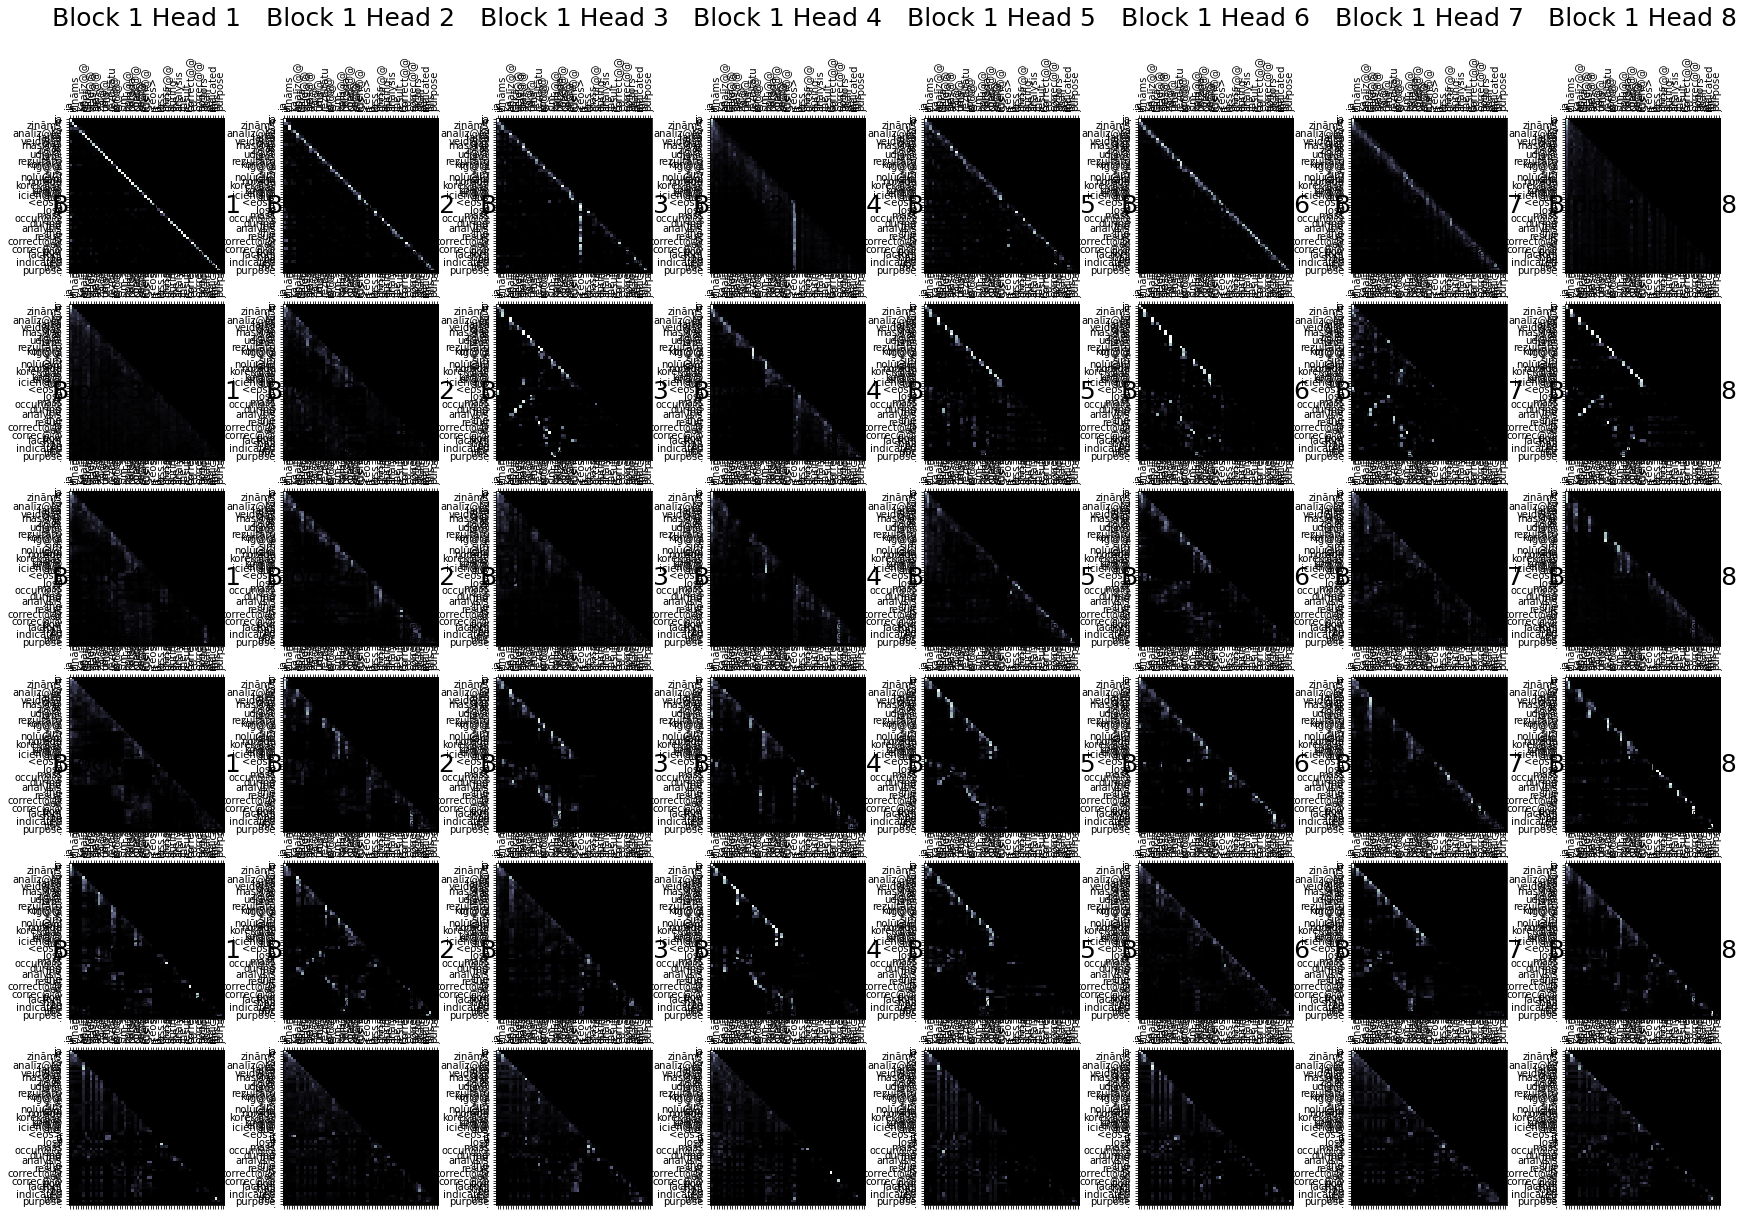

In [39]:
# fig, plots = plt.subplots(nrows=number_of_layers, ncols=number_of_heads, figsize=(30, 20))

# axis_text = tokenizer_input.decode(encoded_input, True).split()

# axis_text.append('<eos>')

# axis_text += tokenizer_input.decode(predicted, True).split()

# limit = len(axis_text)
# for bi in range(number_of_layers):
#     for hi in range(number_of_heads):
#         attetion_plot = torch.zeros(limit, limit)
#         for di in range(limit):
#             attetion_plot[:di, :di] = attention_state[bi][di][0,hi,:di,:di].data

#         ax = plots[bi][hi]
#         ax.matshow(attetion_plot.numpy(), cmap='bone')

#         # Set up axes
#         ax.set_xticklabels([''] + axis_text, rotation=90)
#         ax.set_yticklabels([''] + axis_text)

#         # Show label at every tick
#         ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#         ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#         # Set up a title
#         ax.set_title(f'Block {bi + 1} Head {hi + 1}', size=25, pad=30)
        
# plt.show()

In [40]:
# In case the previous cell is not plotting anything, uncomment the code below and execute. After that, the plotting should be fine.
# %matplotlib inline
# import numpy as np
# x = np.linspace(0, 10, 100)

# fig = plt.figure()
# plt.plot(x, np.sin(x), '-')
# plt.plot(x, np.cos(x), '--');

#Calculate BLEU

In [51]:
def clean_tokens(sentence):
    return sentence.replace('@@ ', '').replace(' @', '').replace('@ ', '')

In [52]:
# import sys
# import time
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# smooth = SmoothingFunction().method7

translation_results = []
eval_text = []

bleu_results = []

num_validation_recs = 10000  #len(valid_input) 161,361 -- would take 55 hours!

pad_tokidx = tokenizer_output.encode(['<pad>'])[0]

for idx, (context,target) in tqdm(enumerate(zip(test_input, test_output)),
                                           total=num_validation_recs):
#     sys.stdout.write('\r'+str(idx)+' / '+str(num_validation_recs))
#     time.sleep(0.1)
##     if (idx+1) % 50 == 0:
##         print(idx, end=" ")
##     if (idx+1) % 100 == 0:
##         print(idx)
    if (idx+1) % (num_validation_recs+1) == 0:
        break
    encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
    x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(cuda1)
    y = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10,
              stop_tokidx=pad_tokidx)[0]

    intent = len(encoded_input) + 1
    predicted = y[intent:]
    completion = clean_tokens(tokenizer_output.decode(predicted, True))
    translation_results.append(completion)
    eval_text.append(clean_tokens(target))
    # bleu = sentence_bleu([eval], completion, smoothing_function=smooth)
    # bleu_results.append(bleu)

with open('tilde_valid.predicted', 'w') as f:
    f.write("\n".join(translation_results))

with open('tilde_valid.gtruth', 'w') as f:
    f.write("\n".join(eval_text))

    # print(f"Averare BLEU: {np.mean(bleu_results)}")

100%|██████████| 10000/10000 [1:17:43<00:00,  2.14it/s]


In [53]:
# num_validation_recs = 2000
# eval_text = []
# for idx, (context,target) in tqdm(enumerate(zip(test_input, test_output)),
#                                             total=num_validation_recs):
#     if (idx+1) % (num_validation_recs+1) == 0:
#         break

#     eval_text.append(clean_tokens(target))

# print(len(eval_text))
# with open('tilde_valid.gtruth', 'w') as f:
#     f.write("\n".join(eval_text))

In [54]:
!perl mosesdecoder/scripts/generic/multi-bleu.perl tilde_valid.gtruth < tilde_valid.predicted

BLEU = 43.66, 72.2/49.9/37.6/29.4 (BP=0.977, ratio=0.977, hyp_len=274375, ref_len=280862)
It is not advisable to publish scores from multi-bleu.perl.  The scores depend on your tokenizer, which is unlikely to be reproducible from your paper or consistent across research groups.  Instead you should detokenize then use mteval-v14.pl, which has a standard tokenization.  Scores from multi-bleu.perl can still be used for internal purposes when you have a consistent tokenizer.


In [55]:
# BLEU = 7.92, 38.4/12.4/4.2/2.0 (BP=1.000, ratio=1.021, hyp_len=9711, ref_len=9509)

# joint_vocab -s 10,000
# BLEU = 8.61, 44.4/15.1/5.5/2.8 (BP=0.852, ratio=0.862, hyp_len=8198, ref_len=9509)

# full joint_vocab
# BLEU = 9.18, 41.7/14.1/5.4/2.8 (BP=0.948, ratio=0.950, hyp_len=9030, ref_len=9509)

# model_best.pt
# BLEU = 13.47, 48.0/19.6/9.4/5.5 (BP=0.908, ratio=0.912, hyp_len=8670, ref_len=9509)

In [56]:
!cat tilde_valid.predicted | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > tilde_valid.detok.predicted
!cat tilde_valid.gtruth | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > tilde_valid.detok.gtruth

Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv


In [57]:
#!pip install sacrebleu
!pip show sacrebleu

Name: sacrebleu
Version: 1.5.1
Summary: Hassle-free computation of shareable, comparable, and reproducible BLEU, chrF, and TER scores
Home-page: https://github.com/mjpost/sacrebleu
Author: Matt Post
Author-email: post@cs.jhu.edu
License: Apache License 2.0
Location: /home/gstrazds/anaconda3/envs/tw131/lib/python3.8/site-packages
Requires: portalocker
Required-by: 


In [58]:
import sacrebleu

with open('tilde_valid.detok.gtruth', 'r') as f:
    eval_ref = [l.strip() for l in f.readlines()]
with open('tilde_valid.detok.predicted', 'r') as f:
    translation_results = [l.strip() for l in f.readlines()]

refs = [eval_ref]
sys = translation_results
bleu = sacrebleu.corpus_bleu(sys, refs)
print(bleu.score)

43.78117224892189


In [83]:
# 7.918993465381516
# joint_vocab -s 10000  8.534786641173136

# full joint_vocab 9.174070997058795

# model_best.pt 
#13.481896471451254

#Interactive translator